#### Import Model

In [67]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os, sys, tqdm, tarfile, pickle
from urllib.request import urlretrieve

from IPython.display import display, Image

# Config the matplotlib backend as plotting inline in NoteBook.
%matplotlib inline

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset/' # Change me to store data elsewhere

def download_progress_hook(t):
    '''
    A hook to report the progress of a download.
    Reports every 5 percent change in download progress.
    
    Example:
    --------
    with tqdm(...) as t:
        urllib.request.urlretrieve(..., reporthook=download_progress_hook(t))
    '''
    last_b = [0]
    
    def update_progress(count=1, blockSize=1, totalSize=None):
        '''<args>:
        count     <int>: optional, Number of blocks transferred so far. [defult: 1]
        blockSize <int>: optional, Size of each block(in tqdm units). [default: 1]
        totalSize <int>: optional, Total size(in tqdm units). If None remains unchanged.
        '''
        if totalSize is not None:
            t.total = totalSize
        t.update((count - last_b[0]) * blockSize)
        last_b[0] = count
        
    return update_progress

def download_file(filename, expected_bytes=None, force=False):
    ''' Download a file if not present, and make sure it's the right size.'''
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Download: %s' % filename)
        with tqdm.tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1) as t:
            filename, _ = urlretrieve(url+filename, dest_filename, 
                                      reporthook=download_progress_hook(t))
            print('\n%s Download Complete!' % filename)
    if expected_bytes:
        statinfo = os.stat(dest_filename)
        not_expected_bytes_error = 'Failed to verify ' + dest_filename + '. Can you get to it with a browser?'
        assert statinfo.st_size == expected_bytes, not_expected_bytes_error
    
    return dest_filename

train_file = download_file('notMNIST_large.tar.gz', 247336696)
test_filename = download_file('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [11]:
def _extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting: %s' % root)
        tar = tarfile.open(filename)
        for tarinfo in tar:
            if tarinfo.isreg():
                print('Extracting File: %s' % tarinfo.name)
                tar.extract(tarinfo, data_root)
            elif tarinfo.isdir():
                print('Extracting Folder: %s' % tarinfo.name)
                tar.extract(tarinfo, data_root)
            else:
                print('Other Something: %s' % tarinfo.name)
    data_folders= [
        os.path.join(root, d) for d in sorted(os.listdir(root))
    ]
    print(data_folders)
    return data_folders

train_folders = _extract(train_file)
test_folders = _extract(test_filename)

./dataset/notMNIST_large already present - Skipping extraction of ./dataset/notMNIST_large.tar.gz.
['./dataset/notMNIST_large/A', './dataset/notMNIST_large/B', './dataset/notMNIST_large/C', './dataset/notMNIST_large/D', './dataset/notMNIST_large/E', './dataset/notMNIST_large/F', './dataset/notMNIST_large/G', './dataset/notMNIST_large/H', './dataset/notMNIST_large/I', './dataset/notMNIST_large/J']
./dataset/notMNIST_small already present - Skipping extraction of ./dataset/notMNIST_small.tar.gz.
['./dataset/notMNIST_small/A', './dataset/notMNIST_small/B', './dataset/notMNIST_small/C', './dataset/notMNIST_small/D', './dataset/notMNIST_small/E', './dataset/notMNIST_small/F', './dataset/notMNIST_small/G', './dataset/notMNIST_small/H', './dataset/notMNIST_small/I', './dataset/notMNIST_small/J']


#### Problem 1:
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

[Sample Dir]: ./dataset/notMNIST_large/A  [Counts]: 52912


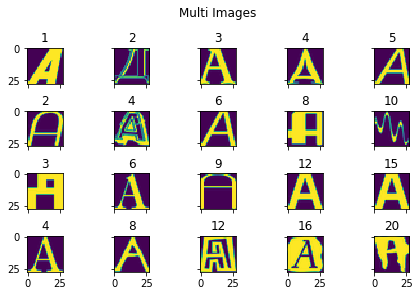

In [63]:
sample_dir = train_folders[0]
sample_all_num = len(os.listdir(sample_dir))
print('[Sample Dir]: %s  [Counts]: %d' % (sample_dir, sample_all_num))
# Select 20 img to show.
samples = os.listdir(sample_dir)[:20]
# Create 4*5 subplots to show img.
Nr = 4
Nc = 5
# constrained_layout: Avoiding labels of different axes overlapping each other.
fig, axs = plt.subplots(Nr, Nc, constrained_layout=True)
fig.suptitle('Multi Images')

samples = np.reshape(samples, (Nr, Nc))
for i in range(Nr):
    for j in range(Nc):
        img_path = os.path.join(sample_dir, samples[i][j])
        sample = plt.imread(img_path)
        axs[i, j].imshow(sample)
        axs[i, j].label_outer()
        axs[i, j].set_title(str((i+1)*(j+1)))

# Layout

plt.show()

Now let's load the data in a more manageable format.
Convert the entire dataset into a 3D array(img index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down and load.

In [51]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder):
    '''Load the data for a single letter label.'''
    image_files = os.listdir(folder)
    img_dataset = np.ndarray(shape=(len(image_files), image_size,
                                    image_size), dtype=np.float32)
    print('[Folder]: %s' % folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) -
            pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            img_dataset[num_images, :, :] = image_data
            num_images += 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
    img_dataset = img_dataset[:num_images, :, :]
    print('Full dataset tensor:', img_dataset.shape)
    print('Mean:', np.mean(img_dataset))
    print('Standard deviation:', np.std(img_dataset))
    return img_dataset

def _pickle(folders, force=False):
    '''
    Load all folders form input and decode it to numpy array,
    then dumps this array to a byte stream file.
    '''
    img_dataset_names = []
    
    for folder in folders:
        set_filename = folder + '.pickle'
        img_dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s' % set_filename)
            img_dataset = load_letter(folder)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(img_dataset, f, pickle.DEFAULT_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
                
    return img_dataset_names

train_datasets = _pickle(train_folders)
test_datasets = _pickle(test_folders)

./dataset/notMNIST_large/A.pickle already present - Skipping pickling.
./dataset/notMNIST_large/B.pickle already present - Skipping pickling.
./dataset/notMNIST_large/C.pickle already present - Skipping pickling.
./dataset/notMNIST_large/D.pickle already present - Skipping pickling.
./dataset/notMNIST_large/E.pickle already present - Skipping pickling.
./dataset/notMNIST_large/F.pickle already present - Skipping pickling.
./dataset/notMNIST_large/G.pickle already present - Skipping pickling.
./dataset/notMNIST_large/H.pickle already present - Skipping pickling.
./dataset/notMNIST_large/I.pickle already present - Skipping pickling.
./dataset/notMNIST_large/J.pickle already present - Skipping pickling.
Pickling ./dataset/notMNIST_small/A.pickle
[Folder]: ./dataset/notMNIST_small/A
Could not read: ./dataset/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could not load bitmap "/home/commaai-03/Mikoy/learn/DeepLearning/Udacity/dataset/notMNIST_small/A/RGVtb2NyYXRpY2FCb2

#### Problem 2:
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

Data Shape: (52909, 28, 28)
Shape: (28, 28)
x[:5]:
 [-0.5 -0.5 -0.5 -0.5 -0.5] 
y[:5]:
 [-0.5 -0.5 -0.5 -0.5 -0.5]


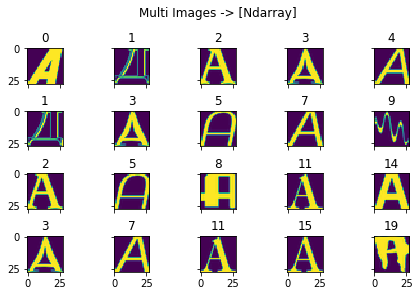

In [70]:
sample_dataset = train_datasets[0]
# Load the pickle data.
with open(sample_dataset, 'rb') as f:
    sample_data = pickle.load(f, encoding='bytes')

print('Data Shape: %s' % str(sample_data.shape))
# Create 4*5 subplots to show img.
Nr = 4
Nc = 5
# constrained_layout: Avoiding labels of different axes overlapping each other.
fig, axs = plt.subplots(Nr, Nc, constrained_layout=True)
fig.suptitle('Multi Images -> [Ndarray]')

for i in range(Nr):
    for j in range(Nc):
        index = (i+1)*(j+1) - 1
        img_data = sample_data[index]
        if index == 0:
            print('Shape: %s' % str(img_data.shape))
            print('x[:5]:\n', img_data[0][:5], '\ny[:5]:\n', img_data[1][:5])
        axs[i, j].imshow(img_data)
        axs[i, j].label_outer()
        axs[i, j].set_title(str(index))

# Layout

plt.show()

Merge and prune the training data as needed.

In [73]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    v_start, t_start = 0, 0
    v_end, t_end = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f, encoding='bytes')
                # Shuffle the letters to have random validation and training set.
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[v_start:v_end] = valid_letter
                    valid_labels[v_start:v_end] = label
                    v_start += vsize_per_class
                    v_end += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l]
                train_dataset[t_start:t_end] = train_letter
                train_labels[t_start:t_end] = label
                t_start += tsize_per_class
                t_end += tsize_per_class
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
            
    return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [76]:
def randomize(dataset, labels):
    # permutation has return but np.random.shuffle not.
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

test_labels

array([6, 9, 6, ..., 6, 8, 0], dtype=int32)

---
#### Problem 4:

Convince yourself that the data is still good aftter shuffling!

In [78]:
# the dict of labels.
label_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D',
              4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def check_after_shuffling(dataset, labels):
    import random
    random_indexes = random.sample(range(len(labels)), 8)
    for i, index in enumerate(random_indexes):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label_dict[labels[index]])
        plt.imshow(dataset[index])

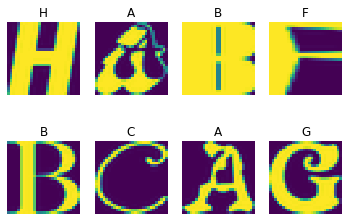

In [79]:
# Check train_dataset and train_label
check_after_shuffling(train_dataset, train_labels)

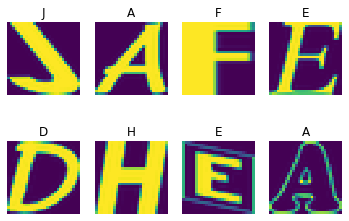

In [80]:
# Check valid_dataset and valid_label
check_after_shuffling(valid_dataset, valid_labels)

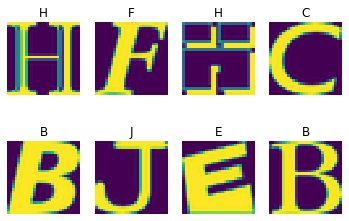

In [81]:
# Check test_dataset and test_label
check_after_shuffling(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [82]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    with open(pickle_file, 'wb') as f:
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Ubable to save data to', pickle_file, ':', e)
    raise

In [83]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In this part, I will explore the dataset and understand better the overlap cases. There are overlaps, but there are also duplicates in the same dataset. Processing time is also critical.

In [97]:
import random
def display_overlap(overlap, source_dataset, target_dataset):
    # Return a random item from list.
    item = random.choice([*overlap])
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

In [85]:
def extract_overlap(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [86]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 49s


Number of overlaps: 29


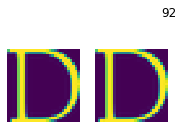

In [102]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

---
#### Manhattan Norm(sum of absolute values.)

In [104]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_near(source_dataset, target_dataset):
    overlap = {}
    for i, s_img in enumerate(source_dataset):
        for j, t_img in enumerate(target_dataset):
            diff = s_img - t_img
            m_norm = np.sum(np.abs(diff))
            if m_norm < MAX_MANHATTAN_NORM:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [105]:
%time overlap_test_train_near = extract_overlap_near(test_dataset[:200], train_dataset)

CPU times: user 3min 51s, sys: 0 ns, total: 3min 51s
Wall time: 3min 51s


Number of near overlaps: 52


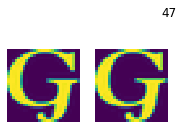

In [106]:
print('Number of near overlaps:', len(overlap_test_train_near.keys()))
display_overlap(overlap_test_train_near, test_dataset[:200], train_dataset)

Stop a the first occurence.

In [109]:
def extract_overlap_stop(source_dataset, target_dataset):
    overlap = {}
    for i, img_1 in enumerate(source_dataset):
        for j, img_2 in enumerate(target_dataset):     
            if np.array_equal(img_1, img_2):
                overlap[i] = [j]
                break
    return overlap

In [110]:
%time overlap_test_train = extract_overlap_stop(test_dataset[:200], train_dataset)

CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
Wall time: 1min 36s


In [113]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_where(source_dataset, target_dataset):
    overlap = {}
    for i, s_img in enumerate(source_dataset):
        diff = target_dataset - s_img
        norm = np.sum(np.abs(diff), axis=1)
        duplicates = np.where(norm > MAX_MANHATTAN_NORM)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [114]:
test_flat = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
%time overlap_test_train = extract_overlap_where(test_flat[:200], train_flat)

CPU times: user 39.6 s, sys: 44.7 s, total: 1min 24s
Wall time: 1min 24s


Number of overlaps: 200


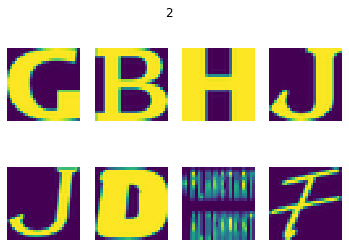

In [115]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

The built-in numpy function provides some improvement either, but this algorithm is still not scalable to the dataset to its full extend.

To make it work at scale, the best option is to use a hash funtion.

In [116]:
import hashlib
def extract_overlap_hash(source_dataset, target_dataset):
    s_hashes = [hashlib.sha256(img).hexdigest() for img in source_dataset]
    t_hashes = [hashlib.sha256(img).hexdigest() for img in target_dataset]
    overlap = {}
    for i, s_hash in enumerate(s_hashes):
        for j, t_hash in enumerate(t_hashes):
            if s_hash == t_hash:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [117]:

%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)

CPU times: user 2.57 s, sys: 3.39 ms, total: 2.57 s
Wall time: 2.57 s


Number of overlaps: 29


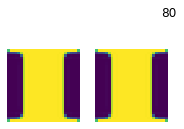

In [118]:

print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

More overlapping values could be found, this is due to the hash collisions. Several images can have the same hash but are actually different differents.

More Faster by using the built-in numpy where function.

In [120]:
def extract_overlap_hash_where(source_dataset, target_dataset):
    s_hashes = np.array([hashlib.sha256(img).hexdigest()
                        for img in source_dataset])
    t_hashes = np.array([hashlib.sha256(img).hexdigest()
                        for img in target_dataset])
    overlap = {}
    for i, s_hash in enumerate(s_hashes):
        duplicates = np.where(t_hashes == s_hash)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [122]:
%time overlap_test_train = extract_overlap_hash_where(test_dataset[:200], train_dataset)

CPU times: user 1.87 s, sys: 24.2 ms, total: 1.89 s
Wall time: 1.89 s


Number of overlaps: 29


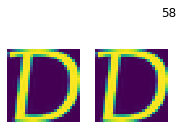

In [123]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [124]:
overlap_test_train

{10: array([140639]),
 12: array([185585, 191178]),
 36: array([ 76699, 127410]),
 41: array([19243, 28634]),
 43: array([132470]),
 48: array([ 53796, 116219]),
 55: array([424]),
 58: array([102302]),
 76: array([79907]),
 79: array([52014]),
 80: array([168159]),
 89: array([50552]),
 92: array([95049]),
 98: array([75960]),
 110: array([85103]),
 117: array([154404]),
 119: array([98785]),
 123: array([ 65407, 173711]),
 127: array([155697]),
 132: array([195117]),
 133: array([149306]),
 141: array([27302]),
 180: array([74519]),
 183: array([  4762, 167389]),
 185: array([12973, 29337]),
 186: array([19121]),
 187: array([43300]),
 189: array([ 43374, 136507]),
 196: array([24002])}

In [130]:
def sanetize(source_dataset, target_dataset):
    # np.delete(arr, obj, axis=None)
    # arr: input array; obj: where should be deleted; axis: which axis should be deleted.
    s_hashes = np.array([hashlib.sha256(img).hexdigest()
                         for img in source_dataset])
    t_hashes = np.array([hashlib.sha256(img).hexdigest()
                         for img in target_dataset])
    overlap = []
    for i, s_hash in enumerate(s_hashes):
        duplicates = np.where(t_hashes == s_hash)
        if len(duplicates[0]):
            overlap.append(i)
    return overlap

In [134]:
%time test_overlap = sanetize(test_dataset, train_dataset)

CPU times: user 30.7 s, sys: 20.6 ms, total: 30.7 s
Wall time: 30.7 s


In [ ]:
# Remove the test overlaps:
test_dataset_sanit = np.delete(test_dataset, test_overlap, axis=0)
test_labels_sanit = np.delete(test_labels, test_overlap, axis=None)
print('Overlapping images removed: ', len(test_overlap))

In [136]:
%time valid_overlap = sanetize(valid_dataset, train_dataset)

CPU times: user 30.5 s, sys: 23.1 ms, total: 30.5 s
Wall time: 30.5 s


In [137]:
# Romove the valid overlaps:
valid_dataset_sanit = np.delete(valid_dataset, valid_overlap, axis=0)
valid_labels_sanit = np.delete(valid_labels, valid_overlap, axis=None)
print('Overlapping images removed: ', len(valid_overlap))

Overlapping images removed:  1073


In [176]:
pickle_file_sanit = os.path.join(data_root, 'noMNIST_sanit.pickle')

try:
    with open(pickle_file_sanit, 'wb') as f:
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset_sanit,
            'valid_labels': valid_labels_sanit,
            'test_dataset': test_dataset_sanit,
            'test_labels': test_labels_sanit,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file_sanit, ':', e)
    raise

In [139]:
sanit_info = os.stat(pickle_file_sanit)
print('Compressed pickle size:', sanit_info.st_size)

Compressed pickle size: 683427350


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [140]:
from sklearn.linear_model import LogisticRegression

In [160]:
print('Data Shape:', test_dataset_sanit.shape)
regr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial', n_jobs=-1,
                         max_iter=1000)

Data Shape: (8736, 28, 28)


In [177]:
X_test = test_dataset_sanit.reshape(test_dataset_sanit.shape[0], 28*28)
Y_test = test_labels_sanit

sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 28*28)
Y_train = train_labels[:sample_size]

%time regr.fit(X_train, Y_train)
regr.score(X_test, Y_test)

CPU times: user 416 ms, sys: 261 ms, total: 677 ms
Wall time: 804 ms


0.5966117216117216

In [153]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 28*28)
Y_train = train_labels[:sample_size]

%time regr.fit(X_train, Y_train)
regr.score(X_test, Y_test)

CPU times: user 9.98 ms, sys: 0 ns, total: 9.98 ms
Wall time: 2.54 s


0.8137591575091575

In [162]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 28*28)
Y_train = train_labels[:sample_size]

%time regr.fit(X_train, Y_train)
regr.score(X_test, Y_test)

CPU times: user 46.1 ms, sys: 271 ms, total: 317 ms
Wall time: 18.3 s


0.8237179487179487

In [163]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 28*28)
Y_valid = valid_labels[:sample_size]
#regr.score(X_valid, Y_valid)
regr.score(X_valid, Y_valid)

0.7568

10000
5000


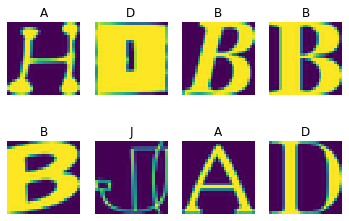

In [168]:
pred_labels = regr.predict(X_valid)
print(len(valid_dataset))
print(len(pred_labels))
check_after_shuffling(valid_dataset[:sample_size], pred_labels)

In [178]:
# To train the model on all the data, we have to use another solver.
# Sag is the faster one.

regr_2 = LogisticRegression(random_state=0, solver='sag',
                          multi_class='multinomial', n_jobs=-1,
                         max_iter=100)

In [179]:
train_dataset.shape

(200000, 28, 28)

In [180]:
X_train = train_dataset.reshape(-1, 28*28)
Y_train = train_labels
%time regr_2.fit(X_train, Y_train)
regr_2.score(X_test, Y_test)

CPU times: user 13min 1s, sys: 0 ns, total: 13min 1s
Wall time: 6min 30s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8890796703296703

200000
200000


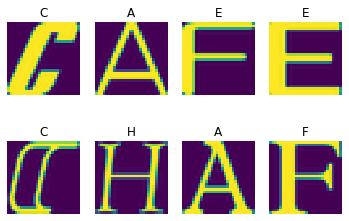

In [183]:
pred_labels = regr.predict(X_train)
print(len(train_dataset))
print(len(pred_labels))
check_after_shuffling(train_dataset, pred_labels)